In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import Comparator, EndogVar, EndogVarConditions, EndogEquation

## Model 1 Laplace Equation Dirichlet Problem.
$$\nabla^2 T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0, T(x,0)=T(x,\pi)=0, T(0,y)=1$$
Solution: $T(x,y) = \frac{2}{\pi} \arctan\frac{\sin y}{\sinh x}$

In [2]:
pde1 = PDEModel("laplace_dirichlet")
pde1.set_state(["x", "y"], {"x": [0, 3.], "y": [0, np.pi]})
pde1.add_endog("T")
pde1.add_endog_equation(r"$\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0$", label="base_pde")

zero_ys = torch.zeros((100, 2))
zero_ys[:, 0] = torch.Tensor(np.linspace(0, 3, 100))
pi_ys = torch.zeros((100, 2))
pi_ys[:, 0] = torch.Tensor(np.linspace(0, 3, 100))
pi_ys[:, 1] = torch.pi

zero_xs = torch.zeros((100, 2))
zero_xs[:, 1] = torch.Tensor(np.linspace(0, np.pi, 100))

pde1.add_endog_condition("T", 
                              "T(SV)", {"SV": zero_ys},
                              Comparator.EQ,
                              "0", {},
                              label="bc_zeroy")
pde1.add_endog_condition("T", 
                              "T(SV)", {"SV": pi_ys},
                              Comparator.EQ,
                              "0", {},
                              label="bc_piy")
pde1.add_endog_condition("T", 
                              "T(SV)", {"SV": zero_xs},
                              Comparator.EQ,
                              "1", {},
                              label="bc_zerox")

print(pde1)
if not os.path.exists("./models/laplace_dirichlet.pt"):
    pde1.train_model("./models", "laplace_dirichlet.pt", True)
else:
    pde1.load_model(torch.load("./models/laplace_dirichlet.pt"))
    pde1.eval_model(True)

=======================Summary of Model laplace_dirichlet=======================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001
}
Latex Variable Mapping: {}

================================State Variables=================================
x: [0, 3.0]
y: [0, 3.141592653589793]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: T
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, out_features=30, bias=True)
    (activation_3): Tanh()
    (final_layer): Linea

C:\Users\yunta\AppData\Local\Temp\ipykernel_21408\2596829883.py:5: RuntimeWarning: divide by zero encountered in divide
  exact_Z = 2. / np.pi * np.arctan(np.sin(Y) / np.sinh(X))
C:\Users\yunta\AppData\Local\Temp\ipykernel_21408\2596829883.py:5: RuntimeWarning: invalid value encountered in divide
  exact_Z = 2. / np.pi * np.arctan(np.sin(Y) / np.sinh(X))


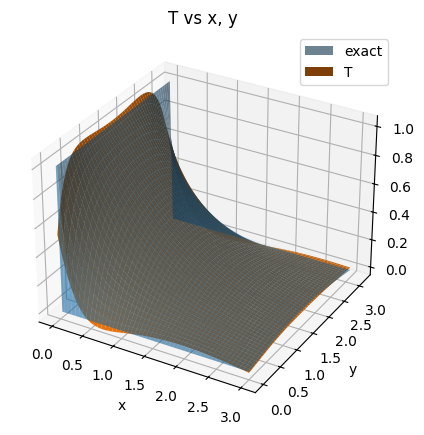

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(0, 3, 100)
y_np = np.linspace(0, np.pi, 100)
X, Y = np.meshgrid(x_np, y_np)
exact_Z = 2. / np.pi * np.arctan(np.sin(Y) / np.sinh(X))
ax.plot_surface(X, Y, exact_Z, label="exact", alpha=0.6)
pde1.endog_vars["T"].plot("T", {"x": [0, 3.], "y": [0, np.pi]}, ax=ax)
plt.subplots_adjust()
plt.show()

## Model 2 Time-dependent Heat Equation
$$\frac{\partial u}{\partial t} = 0.4 \frac{\partial^2 u}{\partial x^2}, x\in [0,1], t\in[0,1],$$ 
$$u(0,t)=u(1,t)=0, u(x,0)=\sin(\pi x)$$

Solution is $u(x,t)=e^{-0.4\pi^2t} \sin(\pi x)$

In [4]:
pde2 = PDEModel("time_heat")
pde2.set_state(["x", "t"], {"x": [0, 1.], "t": [0, 1.]})
pde2.add_endog("u")
pde2.add_endog_equation(r"$\frac{\partial u}{\partial t} = 0.4 * \frac{\partial^2 u}{\partial x^2}$", label="base_pde")

zero_xs = torch.zeros((100, 2))
zero_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

one_xs = torch.ones((100, 2))
one_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

zero_ts = torch.zeros((100, 2))
zero_ts[:, 0] = torch.Tensor(np.linspace(0, 1, 100))
u_zero_ts = torch.sin(torch.pi * zero_ts[:, 0:1])

pde2.add_endog_condition("u", 
                              "u(SV)", {"SV": zero_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_zerox")
pde2.add_endog_condition("u", 
                              "u(SV)", {"SV": one_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_onex")
pde2.add_endog_condition("u", 
                              "u(SV)", {"SV": zero_ts},
                              Comparator.EQ,
                              "u_zero_ts", {"u_zero_ts": u_zero_ts},
                              label="ic")

print(pde2)
if not os.path.exists("./models/time_heat.pt"):
    pde2.train_model("./models", "time_heat.pt", True)
else:
    pde2.load_model(torch.load("./models/time_heat.pt"))
    pde2.eval_model(True)

===========================Summary of Model time_heat===========================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001
}
Latex Variable Mapping: {}

================================State Variables=================================
x: [0, 1.0]
t: [0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, out_features=30, bias=True)
    (activation_3): Tanh()
    (final_layer): Linear(in_features=

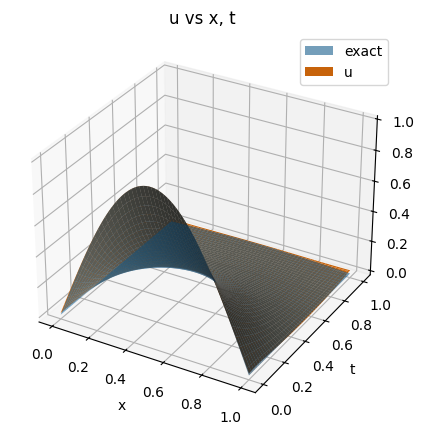

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(0, 1, 100)
t_np = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_np, t_np)
exact_Z = np.exp(-0.4*np.pi**2 * T) * np.sin(np.pi*X)
ax.plot_surface(X, T, exact_Z, label="exact", alpha=0.6)
pde2.endog_vars["u"].plot("u", {"x": [0, 1.], "y": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()